In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error as MSE
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso,
    TheilSenRegressor, RANSACRegressor, HuberRegressor,
    )



In [2]:
# load Training Set
x_train = np.load("Xtrain_Regression_Part2.npy")
y_train = np.load("Ytrain_Regression_Part2.npy")
x_test = np.load("Xtest_Regression_Part2.npy")

# DF

In [3]:
import string
df = pd.DataFrame(x_train, columns=list(string.ascii_uppercase)[:20])
df["y"] = y_train

# summarize the shape of the training dataset
print(df.shape)
print(df.columns)

(100, 21)
Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'y'],
      dtype='object')


# Interquartile Range Method (IQR)

In [5]:
# IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
# print(IQR)
# print(Q3)
# (Q3 + 1.5 * IQR)

In [6]:
# summarize the shape of the training dataset
print(df.shape)

(100, 21)


In [7]:
# Finding outliers using IQR
outliers = (df < (Q1 - 1.5 * IQR)).astype(bool) | (df > (Q3 + 1.5 * IQR)).astype(bool)
# print(-outliers)

## Model's MSE metics

In [20]:
def mse_linear_model(X, Y, runs=500) -> float:
    mse = 0
    for _ in range(runs):
        # split into train and test sets
        train_x, test_x, train_y, test_y = train_test_split(X,
                                                            Y,
                                                            train_size=0.9)
        # fit the model
        lr = LinearRegression().fit(train_x, train_y)       
        # evaluate the model
        pred_y = lr.predict(test_x)
        # evaluate predictions
        mse = mse + MSE(test_y, pred_y)
    # summarize the shape of the updated training dataset
    # print(train_x.shape, train_y.shape) 
    # print('MSE:', mse/runs)
    return mse/runs

In [4]:
def mse_of_models_lr_ridg_lass(X, Y, cv_folds: int=10, 
                    alpha_min:float = 0.0001,
                    alpha_max:float = 0.01):

    results = pd.DataFrame()
    for a in np.linspace(alpha_min, alpha_max, 100):
        estimators = [('Linear', LinearRegression()),
                      ('Lasso', Lasso(alpha=a)),
                      ('Ridge', Ridge(alpha=a)),
                      ]

        for name, estimator in estimators:
            neg_mse = cross_val_score(estimator, X, Y, cv=cv_folds,
                                scoring='neg_mean_squared_error')
            neg_mse = np.average(neg_mse)
            # print(f"{name} -> Alpha: {a:.4f}\t\t-MSE score:{neg_mse:.4f}")
            results.loc[name,a] = neg_mse

    # get best model / alpha
    a, b = results.stack().idxmax()
    print(results.loc[[a], [b]])

    return results.max().max()

In [21]:
X = df.drop("y", axis=1)
Y = df["y"]
mse_linear_model(X, Y)

2.4295241815679542

## Outlier cleaning Evaluation

Test some outlier identification methods, clean those outliers form training dataset and get mse metric for linear regression model.

TODO:
+ Test different contamination effects
+ Test score with different regression models
+ Clean warnings

### Malanobis Distance of X_train and Y_train

In [78]:
# local project path imports
from mahalanobis import mahalanobis

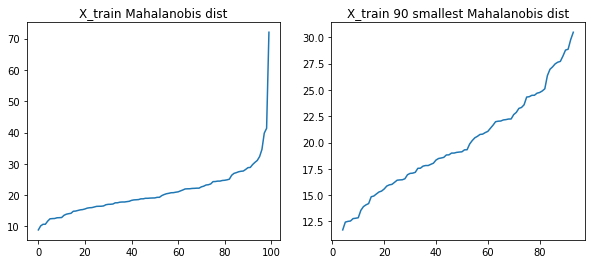

In [93]:
mahal = pd.DataFrame()
mahal["mahal"] = mahalanobis(df, df)
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(mahal.sort_values("mahal").reset_index(drop=True))
ax1.set_title("X_train Mahalanobis dist")
ax2.plot(mahal.sort_values("mahal").reset_index(drop=True)[4:94])
ax2.set_title("X_train 90 smallest Mahalanobis dist")
fig.set_figwidth(10)

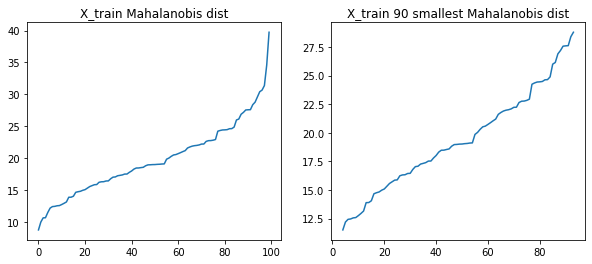

In [94]:
mahal_x = pd.DataFrame()
mahal_x["mahal"] = mahalanobis(pd.DataFrame(x_train), pd.DataFrame(x_train))
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(mahal_x.sort_values("mahal").reset_index(drop=True))
ax1.set_title("X_train Mahalanobis dist")
ax2.plot(mahal_x.sort_values("mahal").reset_index(drop=True)[4:94])
ax2.set_title("X_train 90 smallest Mahalanobis dist")
fig.set_figwidth(10)

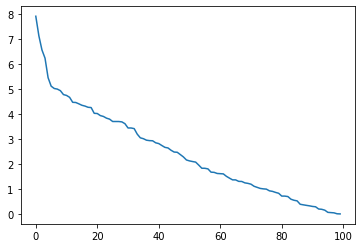

In [117]:
dist = np.sqrt(np.square(y_train - y_train.mean()))
plt.plot(np.sort(dist, axis=0)[::-1])

### Experiments with outlier detetion

* IsolationForest
* EllipticEnvelope
* LocalOutlierFactor

In [74]:
def run_experiment_with_outlier_detection(mse_of_model , 
                                    data_x_y: pd.DataFrame, 
                                    contamination: float, 
                                    show_plot=True):    
    
    evaluation = pd.DataFrame(columns=["mse"])
    # IsolationForest - efficient way of performing outlier detection in 
    #   high-dimensional datasets.
    #   ‘isolates’ observations by randomly selecting a feature and then
    #   randomly selecting a split value between the maximum and minimum 
    #   values of the selected feature.

    # EllipticEnvelope - assumes the data is Gaussian and learns an ellipse. 
    #   It thus degrades when the data is not unimodal. 
    #   Notice however that this estimator is robust to outliers.
    #   The Mahalanobis distances obtained from this estimate is used to derive a measure of outlyingness

    # Local Outlier Factor:
    # n_neighbors) is typically set 
    #   1) greater than the minimum number of samples a cluster has to contain, 
    #       so that other samples can be local outliers relative to this cluster, and 
    #   2) smaller than the maximum number of close by samples that can potentially be 
    #       local outliers. In practice, such informations are generally not available, 
    #       and taking **n_neighbors=20** appears to work well in general.

    outlier_detection_methods = [('Baseline', None),
                ('Isolation Forest', IsolationForest),
                ('Minimum Covariance Determinant', EllipticEnvelope),
                ('Local Outlier Factor', LocalOutlierFactor)]

    if show_plot:
        fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)
        ax_plots = { "Baseline": ax1, 
                "Isolation Forest": ax2, 
                "Minimum Covariance Determinant": ax3, 
                "Local Outlier Factor": ax4}


    for name, outlier_detection in outlier_detection_methods:
        if outlier_detection:
            is_outlier = outlier_detection(contamination=contamination).fit_predict(data_x_y)
        else:
            is_outlier = np.ones(df.index.size)
        # select all rows that are not outliers
        mask = is_outlier != -1
        # print(mask)
        
        X = data_x_y[mask].drop("y", axis=1)
        Y = data_x_y[mask]["y"]
        # print(name, Y.size, Y.index)
        evaluation.loc[name, "mse"] = mse_of_model(X, Y)

        # Check if outlier detection method produces population with less mahalanobis distance 
        # considering the full dataset (x and y) as the distribution
        if show_plot:
            mahal_of_outlier_detection = pd.DataFrame()
            mahal_of_outlier_detection["mahal_d"] = mahalanobis(data_x_y[mask], data_x_y)
            ax_plots[name].plot(mahal_of_outlier_detection.sort_values("mahal_d").reset_index(drop=True))
            ax_plots[name].set_title(name)

    if show_plot:
        plt.subplots_adjust(wspace=0.20, hspace=0.5)
        # plt.title("Mahalanobis Distance")
        plt.show()
    return evaluation

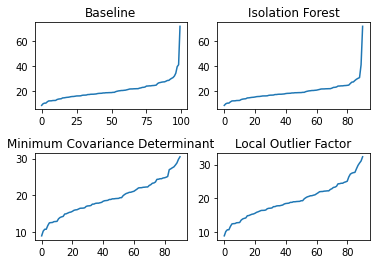

Linear Model experiment
                                      mse
Baseline                          2.03212
Isolation Forest                  2.03594
Minimum Covariance Determinant  0.0158659
Local Outlier Factor             0.017743


In [68]:
results = run_experiment_with_outlier_detection(mse_linear_model, df, contamination=0.04)
print("Linear Model experiment")
print(results)

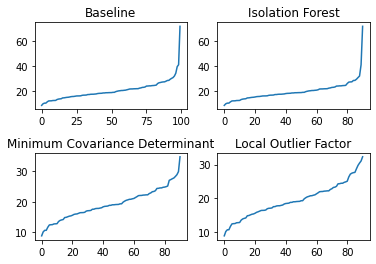

Linear Model experiment
                                      mse
Baseline                          2.20903
Isolation Forest                  2.33145
Minimum Covariance Determinant  0.0155645
Local Outlier Factor            0.0171081


In [60]:
results = run_experiment_with_outlier_detection(mse_linear_model, df, contamination=0.1)
print("Linear Model experiment")
print(results)

Multimodel experiment
           0.01
Lasso -2.033188
           0.01
Lasso -2.068552
           0.01
Lasso -0.714894
           0.01
Lasso -2.068552


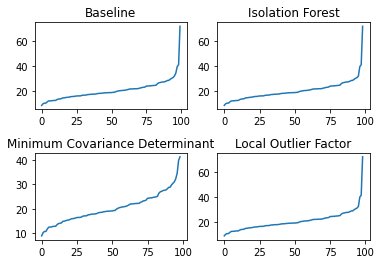

Best results
                                     mse
Baseline                        -2.03319
Isolation Forest                -2.06855
Minimum Covariance Determinant -0.714894
Local Outlier Factor            -2.06855


In [71]:
print("Multimodel (Linear, Lasso, Ridge) experiment")
results = run_experiment_with_outlier_detection(mse_of_models_lr_ridg_lass, df, contamination=0.01)
print("Best results")
print(results)

Multimodel experiment
           0.01
Lasso -2.033188
           0.01
Lasso -2.211825
         0.0013
Lasso -0.018006
           0.01
Lasso -2.208749


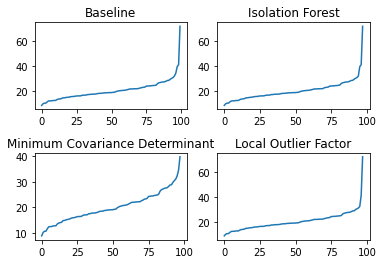

Best results
                                      mse
Baseline                         -2.03319
Isolation Forest                 -2.21183
Minimum Covariance Determinant -0.0180063
Local Outlier Factor             -2.20875


In [72]:
print("Multimodel experiment")
results = run_experiment_with_outlier_detection(mse_of_models_lr_ridg_lass, df, contamination=0.02)
print("Best results")
print(results)

In [80]:
for contamination in range(1,11):
    print(f"Multimodel experiment with {contamination} contamination factor")
    results = run_experiment_with_outlier_detection(mse_of_models_lr_ridg_lass, 
                                                    df,
                                                    contamination=0.01*contamination, show_plot=False)
    print("Best results")
    print(results)

Multimodel experiment with 1 contamination factor
           0.01
Lasso -2.033188
           0.01
Lasso -2.068552
           0.01
Lasso -0.714894
           0.01
Lasso -2.068552
Best results
                                     mse
Baseline                        -2.03319
Isolation Forest                -2.06855
Minimum Covariance Determinant -0.714894
Local Outlier Factor            -2.06855
Multimodel experiment with 2 contamination factor
           0.01
Lasso -2.033188
           0.01
Lasso -2.208749
         0.0013
Lasso -0.018006
           0.01
Lasso -2.208749
Best results
                                      mse
Baseline                         -2.03319
Isolation Forest                 -2.20875
Minimum Covariance Determinant -0.0180063
Local Outlier Factor             -2.20875
Multimodel experiment with 3 contamination factor
           0.01
Lasso -2.033188
           0.01
Lasso -2.263319
          0.0001
Linear -0.017836
           0.01
Lasso -2.216763
Best results
          

# Robust Fit

In [63]:
def mse_robust_models(X, Y, cv_folds: int=10):
    results = pd.DataFrame()
    # estimators = [('OLS', LinearRegression()),
    estimators = [('Theil-Sen', TheilSenRegressor()),
                ('RANSAC', RANSACRegressor()),
                ('HuberRegressor', HuberRegressor())]

    for name, estimator in estimators:
        model_mse = cross_val_score(estimator, X, Y, cv=cv_folds,
                            scoring='neg_mean_squared_error')
        results.loc[name, "mse"] = np.average(model_mse)
        
    print(results.loc[results.idxmax()])
    best_mean_score = results.max().max()
    #print(type(best_mean_score))
    #print(best_mean_score)
    return best_mean_score


Robust Models experiment with outlier detection/removal
                mse
Theil-Sen -1.657685
                mse
Theil-Sen -1.838678
                     mse
HuberRegressor -0.016281
                mse
Theil-Sen -0.017393


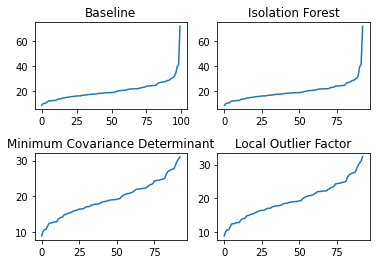

Best model results
                                      mse
Baseline                         -1.65769
Isolation Forest                 -1.83868
Minimum Covariance Determinant -0.0162807
Local Outlier Factor           -0.0173934


In [79]:
print("Robust Models experiment with outlier detection/removal")
results = run_experiment_with_outlier_detection(mse_robust_models, df, contamination=0.07)
print("Best model results")
print(results)

In [11]:
print("Robust Models experiment")
results = mse_robust_models(df.drop("y", axis=1), df["y"])
print("Best model MSE")
print(results)

                mse
Theil-Sen -1.656391
Multimodel experiment
-1.6563910530501693


# Final calc

In [24]:
# Best Outlier Detector : EllipticEnvelope
# Best Contamination Factor: 10
# Best Model: Lasso
results = pd.DataFrame(columns=["mse"])

alpha_min = 0.0001
alpha_max = 0.0100
N = 10
cv_folds = 10

best_model = LinearRegression()
best_model_mse_estimation = -100

for contamination in [9, 10]:
    print(f"Multimodel experiment with {contamination} contamination factor")

    mse = 0
    for _ in range(N):
        is_outlier = EllipticEnvelope(contamination=0.01*contamination).fit_predict(df)
        mask = is_outlier != -1
        X = df[mask].drop("y", axis=1)
        Y = df[mask]["y"]

        # Linear Model
        estimator = LinearRegression()
        neg_mse_lin = np.average(cross_val_score(estimator, X, Y, cv=cv_folds,
                                scoring='neg_mean_squared_error'))
        
        # Lasso Model
        neg_mse_lass = -100
        best_alpha = alpha_min
        for a in np.linspace(alpha_min, alpha_max, 100):
            estimator = Lasso(alpha=a)
            neg_mse = np.average(cross_val_score(estimator, X, Y, cv=cv_folds,
                                scoring='neg_mean_squared_error'))
            if neg_mse_lass < neg_mse:
                neg_mse_lass = neg_mse
                best_alpha = a

        # mse of run
        if neg_mse_lin < neg_mse_lass:
            print(f"mse={neg_mse_lass}, Lasso alpha={best_alpha}")
            mse += neg_mse_lass
            # update best model
            if best_model_mse_estimation < neg_mse_lass:
                best_model_mse_estimation = neg_mse_lass
                best_model = Lasso(alpha=best_alpha)
                print(f"NEW Best Model Lasso alpha={best_alpha}")
        else:
            print(f"mse={neg_mse_lin}, Linear")
            mse += neg_mse_lin
            # update best model
            if best_model_mse_estimation < neg_mse_lass:
                best_model_mse_estimation = neg_mse_lass
                best_model = LinearRegression()
                print(f"NEW Best Model Linear alpha={best_alpha}")
    results.loc[contamination ,"mse"] = mse/N

print("Best results")
print(results)

best_model.fit(X, Y)
y_hat = best_model.predict(x_test)

np.save(f"y_hat_regression_prob2-{np.random.randint(1, 100)}", y_hat)

Multimodel experiment with 9 contamination factor
mse=-0.015766647176132426, Lasso alpha=0.0013000000000000002
NEW Best Model Lasso alpha=0.0013000000000000002
mse=-0.015813847646252488, Lasso alpha=0.0033
mse=-0.015785211772056554, Lasso alpha=0.0028
mse=-0.015766647176132426, Lasso alpha=0.0013000000000000002
mse=-0.017520400323846184, Lasso alpha=0.0005
mse=-0.016177832630574897, Lasso alpha=0.0033
mse=-0.017911378165586106, Lasso alpha=0.0027
mse=-0.017987048928583937, Lasso alpha=0.004600000000000001
mse=-0.01517257588956846, Lasso alpha=0.0017000000000000001
NEW Best Model Lasso alpha=0.0017000000000000001
mse=-0.015894688551621006, Lasso alpha=0.0025
Multimodel experiment with 10 contamination factor
mse=-0.015730448537394307, Lasso alpha=0.0016
mse=-0.016302361735838843, Lasso alpha=0.0024
mse=-0.014399346339500957, Lasso alpha=0.004900000000000001
NEW Best Model Lasso alpha=0.004900000000000001
mse=-0.01567921210289479, Lasso alpha=0.0008
mse=-0.018205541433254722, Lasso alpha

# Boxplot

In [55]:
print(df.shape)
df.head()

(100, 21)


,A,B,C,D,E,F,G,H,I,J,...,L,M,N,O,P,Q,R,S,T,y
0,-1.290089,0.038961,0.228235,0.101686,-0.067296,-0.637278,-0.295017,-0.450571,-2.405162,2.328489,...,-0.675255,0.288608,0.282775,0.217768,0.929042,0.705605,0.130496,-1.616716,0.004275,-4.496486
1,0.963710,1.841056,1.251256,-1.603235,0.340050,-0.233890,1.726259,0.485200,-1.555082,0.872393,...,-0.114605,-0.448800,1.338183,2.203141,-0.179866,0.134610,-0.198595,0.499642,-1.133330,-1.630203
2,0.652553,0.533144,-1.787609,-1.169125,-0.525402,0.257441,-0.629267,0.162554,-0.985946,-1.245303,...,0.427465,0.834908,1.686784,0.051292,-0.870790,0.127209,-0.190596,-1.363593,1.465699,1.339833
3,-0.410840,-1.257023,-0.017595,1.313880,-0.521560,2.934458,-0.520630,0.063651,-1.141947,-0.251534,...,-0.703005,1.106951,0.580637,-0.057783,-0.766014,1.569594,-0.361484,0.436235,-0.449029,-2.496278
4,-1.769616,-1.289050,1.572451,-1.764423,0.354585,-0.484731,-0.487435,-0.158962,0.467395,0.952608,...,1.599535,0.874688,0.638029,1.557111,1.344622,0.745231,0.274891,2.472565,1.583625,4.326055


In [56]:
def plot_boxplot(df):
    df.boxplot()
    plt.grid(False)
    plt.show()

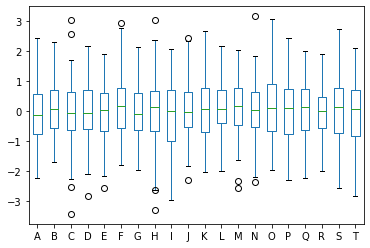

In [57]:
plot_boxplot(df.drop("y", axis=1))

# Histogram

<AxesSubplot:ylabel='Count'>

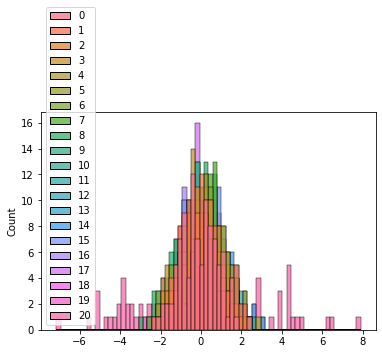

In [87]:
# Did not run... image on cache

#sns.histplot(data=df)
sns.histplot(data=df.drop("y", axis=1))